Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to remove X01 contamination out of GRB 190829A in epochs 201909 and 201910 for both G102 and G141.

# Previously
In 20200821/01_X01_photometry.ipynb, we verified that X01 is a stable star. 

We also examined the GRB 190829A dataset visually, and found that X01 is isolated on a flat background. The orientations of epochs 201911 and 202001 show X01 being potential to be used as a template. However, contamination might come from two objects to the left. Locations of these objects in idwbk3z0q_flt frame are:
- X01 -- (230.303,142.567)
- C01 -- (149.030,163.272), galaxy in circular radius 10 pix
- C02 -- (124.475,133.690), galaxy in circular radius 10 pix

The contamination from C02 is more likely than C01, and more likely in G141 at the head of X01.

# Task
- Extract X01 201911 G102 from drzblot:
 - extraction width halfdy >= 5
 - background norder should be very low, and also try masking out its head due to contamination.
- Perform similarly to 202001, and compare. This should be relative the same since X01 is a stable star.

# Something to think about while doing this
Since we want to remove X01 out from GRB 190829A, we would like to get a product that can complete this task.
- Method1: making a clean 2D spectrum of X01 G102 for direct subtraction from other frame.
- Method2: extract 1D spectrum of X01 G102, then use Gaussian model to estimate contamination.

Method2 should be easier in term of mathematics, but require some more codes.


In [2]:
from hstphot.read_ds9region import read_ds9region
from hstgrism.container import Container
# from hstgrism.confreader import ConfReader
# from hstgrism.computesip import ComputeSIP
# from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy


In [3]:
gfile = ('/Users/kbhirombhakdi/_work/GRB190829A/01_making_drzblot/drzblot_GRB190829A_201911_G102/idwbk3z1q_flt.fits',1)
dfile = ('/Users/kbhirombhakdi/_work/_data/15510/mastDownload/HST/idwbk3z0q/idwbk3z0q_flt.fits',1)
ds9file = '/Users/kbhirombhakdi/_work/_data/15510/mastDownload/HST/idwbk3z0q/idwbk3z0q.reg'
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F105W.V4.32.conf'
flatfile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/WFC3.IR.G102.flat.2.fits'
beam = 'A'


In [4]:
sourcename = 'X01'
dateobs = '201911'
filterobs = 'G102'
identifier = '{0}_{1}_{2}'.format(sourcename,dateobs,filterobs)
containerobj = Container(identifier,identifier,'pdf',False)


In [5]:
xyd = read_ds9region(ds9file)[sourcename] - np.array([1.,1.])
xydiff = 'default'
xyoff = 'default'
container = containerobj
t = ComputeXYREF(xyd,xydiff,xyoff,confile,beam,gfile,dfile,container)
t.compute()
t.save()


Save ./X01_201911_G102/X01_201911_G102_xyref.csv


In [14]:
xyref = pd.read_csv('./{0}/{0}_xyref.csv'.format(identifier)).xyref.values
xgbound=(25, 250)
container = containerobj
gobj = WFC3IRG102(confile,beam,xyref,xgbound,container)
gobj.compute()
gobj.save()


Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./X01_201911_G102/X01_201911_G102_trace.csv


Save ./X01_201911_G102/X01_201911_G102_overview.pdf



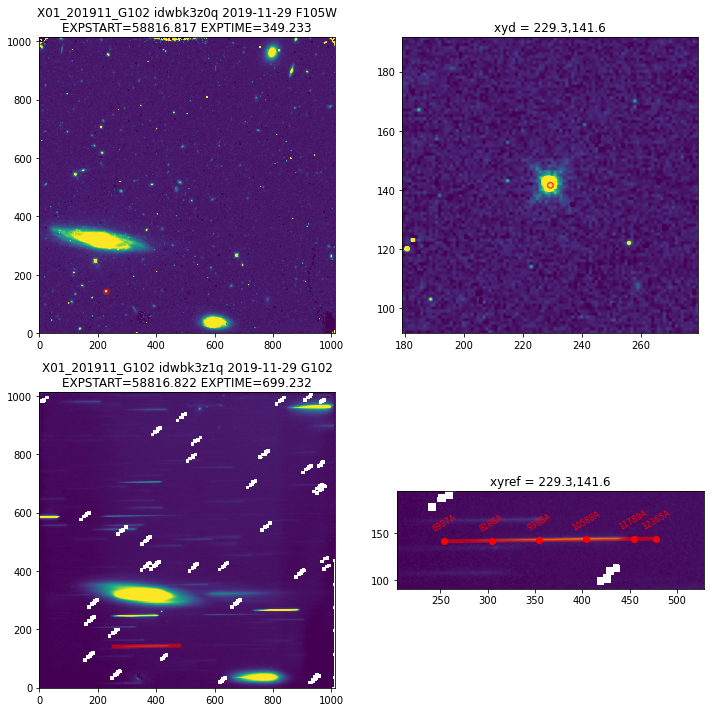

In [16]:
trace = pd.read_csv('./{0}/{0}_trace.csv'.format(identifier))
xh = trace.xh.values
yh = trace.yh.values
ww = trace.ww.values
objname = identifier
save = True
containter = containerobj
show_overview(gfile,dfile,xyd,xyref,xh,yh,ww,objname,save,container)


In [30]:
xg = xh + xyref[0]
yg = yh + xyref[1]
halfdy = 7
tbox={'xg': xg, 'yg': yg, 'halfdyup': halfdy, 'halfdylow': halfdy}
bbox={'padxleft': 3, 'padxright': 3, 'padyup': 15, 'padylow': 15}
image = fits.open(gfile[0])[gfile[1]].data
container = containerobj
cutobj = Cutout2D(tbox,bbox,image,container)
cutobj.compute()
cutobj.save()


Save ./X01_201911_G102/X01_201911_G102_tbox.csv
Save ./X01_201911_G102/X01_201911_G102_bbox.csv
Save ./X01_201911_G102/X01_201911_G102_bbcorner.csv
Save ./X01_201911_G102/X01_201911_G102_cutout.fits
Save ./X01_201911_G102/X01_201911_G102_mask.fits


Save ./X01_201911_G102/X01_201911_G102_bbox.pdf


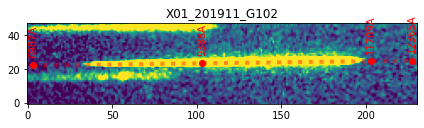

In [31]:
cutoutdata = fits.open('./{0}/{0}_cutout.fits'.format(identifier))[1].data
objname = identifier
# maskdata = fits.open('./{0}/{0}_mask.fits'.format(identifier))[1].data
maskdata = None
do_trace = True
bb0x = pd.read_csv('./{0}/{0}_bbcorner.csv'.format(identifier)).bb0x.values[0]
bb0y = pd.read_csv('./{0}/{0}_bbcorner.csv'.format(identifier)).bb0y.values[0]
xcut = xh + xyref[0] - bb0x
ycut = yh + xyref[1] - bb0y
ww = trace.ww.values
save = True
container = containerobj
show_bbox(cutoutdata=cutoutdata,objname=objname,maskdata=maskdata,
          do_trace=do_trace,xcut=xcut,ycut=ycut,ww=ww,save=save,container=container
         )


In [ ]:
FlatField()

# Summary
We stopped here because we realized that we have to make a new drzblot with a new flatfield properly set with X01.


In [ ]:
# FlatField
# Background
# GrismApCorr